# DEMO: Contract Understanding with OpenAI GPT

In [ ]:
%%bash
pip install chromadb
pip install langchain
pip3 install PIL
pip3 install pytesseract
pip3 install pdf2image
sudo apt-get install tesseract-ocr -y
apt-get install poppler-utils -y

In [68]:
from PIL import Image as PILImage
from utils.utils import image_export_to_html


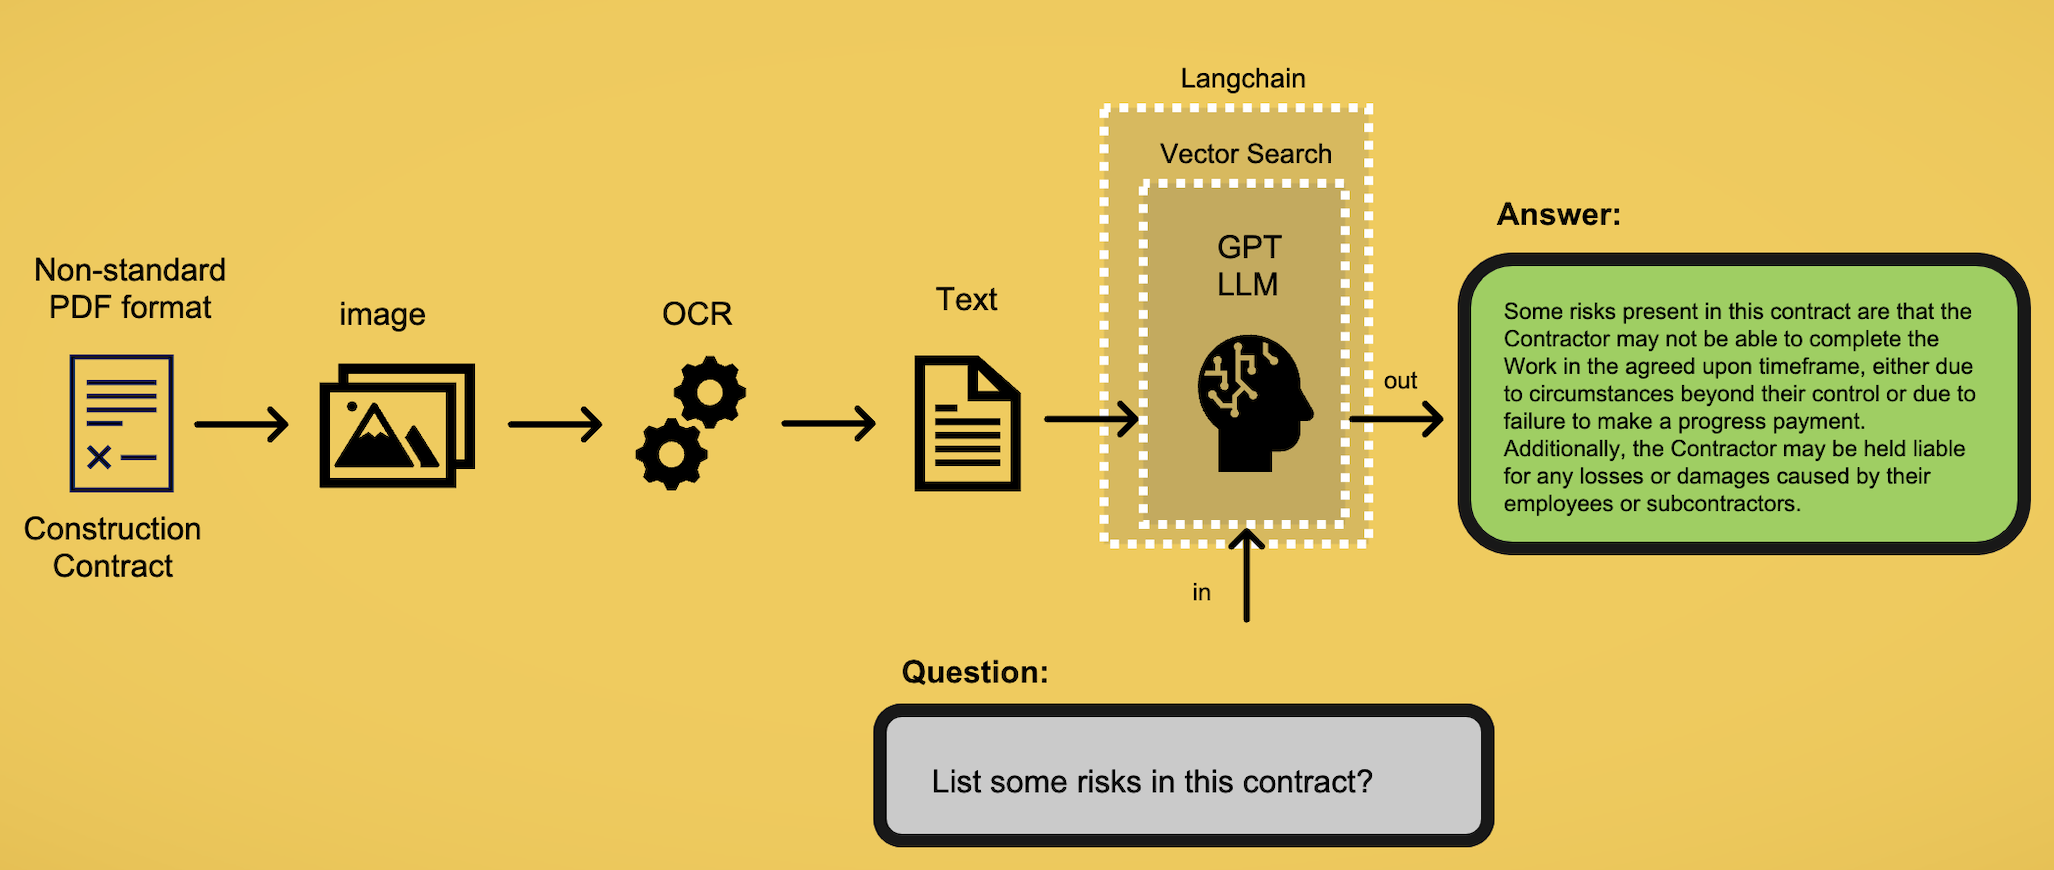

In [71]:
html = image_export_to_html("../static/system.png", 800,400)
IPython.display.HTML(html)

# STEP 1: Convert PDF -> Image -> Text Extraction OCR

In [1]:
# Import libraries
import platform
from tempfile import TemporaryDirectory
from pathlib import Path
 
import pytesseract
from pdf2image import convert_from_path
from PIL import Image

In [2]:
PDF_file = "../data/amwins/pdf/contract_demo.pdf"

In [3]:
# read pdf to image
pdf_pages = convert_from_path(PDF_file, 500)

# convert pdf to JPEG 

In [4]:
image_file_list = []
for page_enumeration, page in enumerate(pdf_pages, start=0):
    # enumerate() "counts" the pages for us.
    # Create a file name to store the image
    filename = f"../data/amwins/img/page_{page_enumeration}.jpg"
    # Save the image of the page in system
    page.save(filename, "JPEG")
    image_file_list.append(filename)

# JPEG to TEXT via OCR

In [5]:
text_file = "../data/amwins/txt/contract_demo.txt"
with open(text_file, "a") as output_file:
    # Open the file in append mode
    for image_file in image_file_list:
        # Recognize the text as string in image using pytesserct
        text = str(((pytesseract.image_to_string(Image.open(image_file)))))
 
        # The recognized text is stored in variable text
        # Any string processing may be applied on text
        text = text.replace("-\n", "")
 
                # Finally, write the processed text to the file.
        output_file.write(text)

# Sample of final result


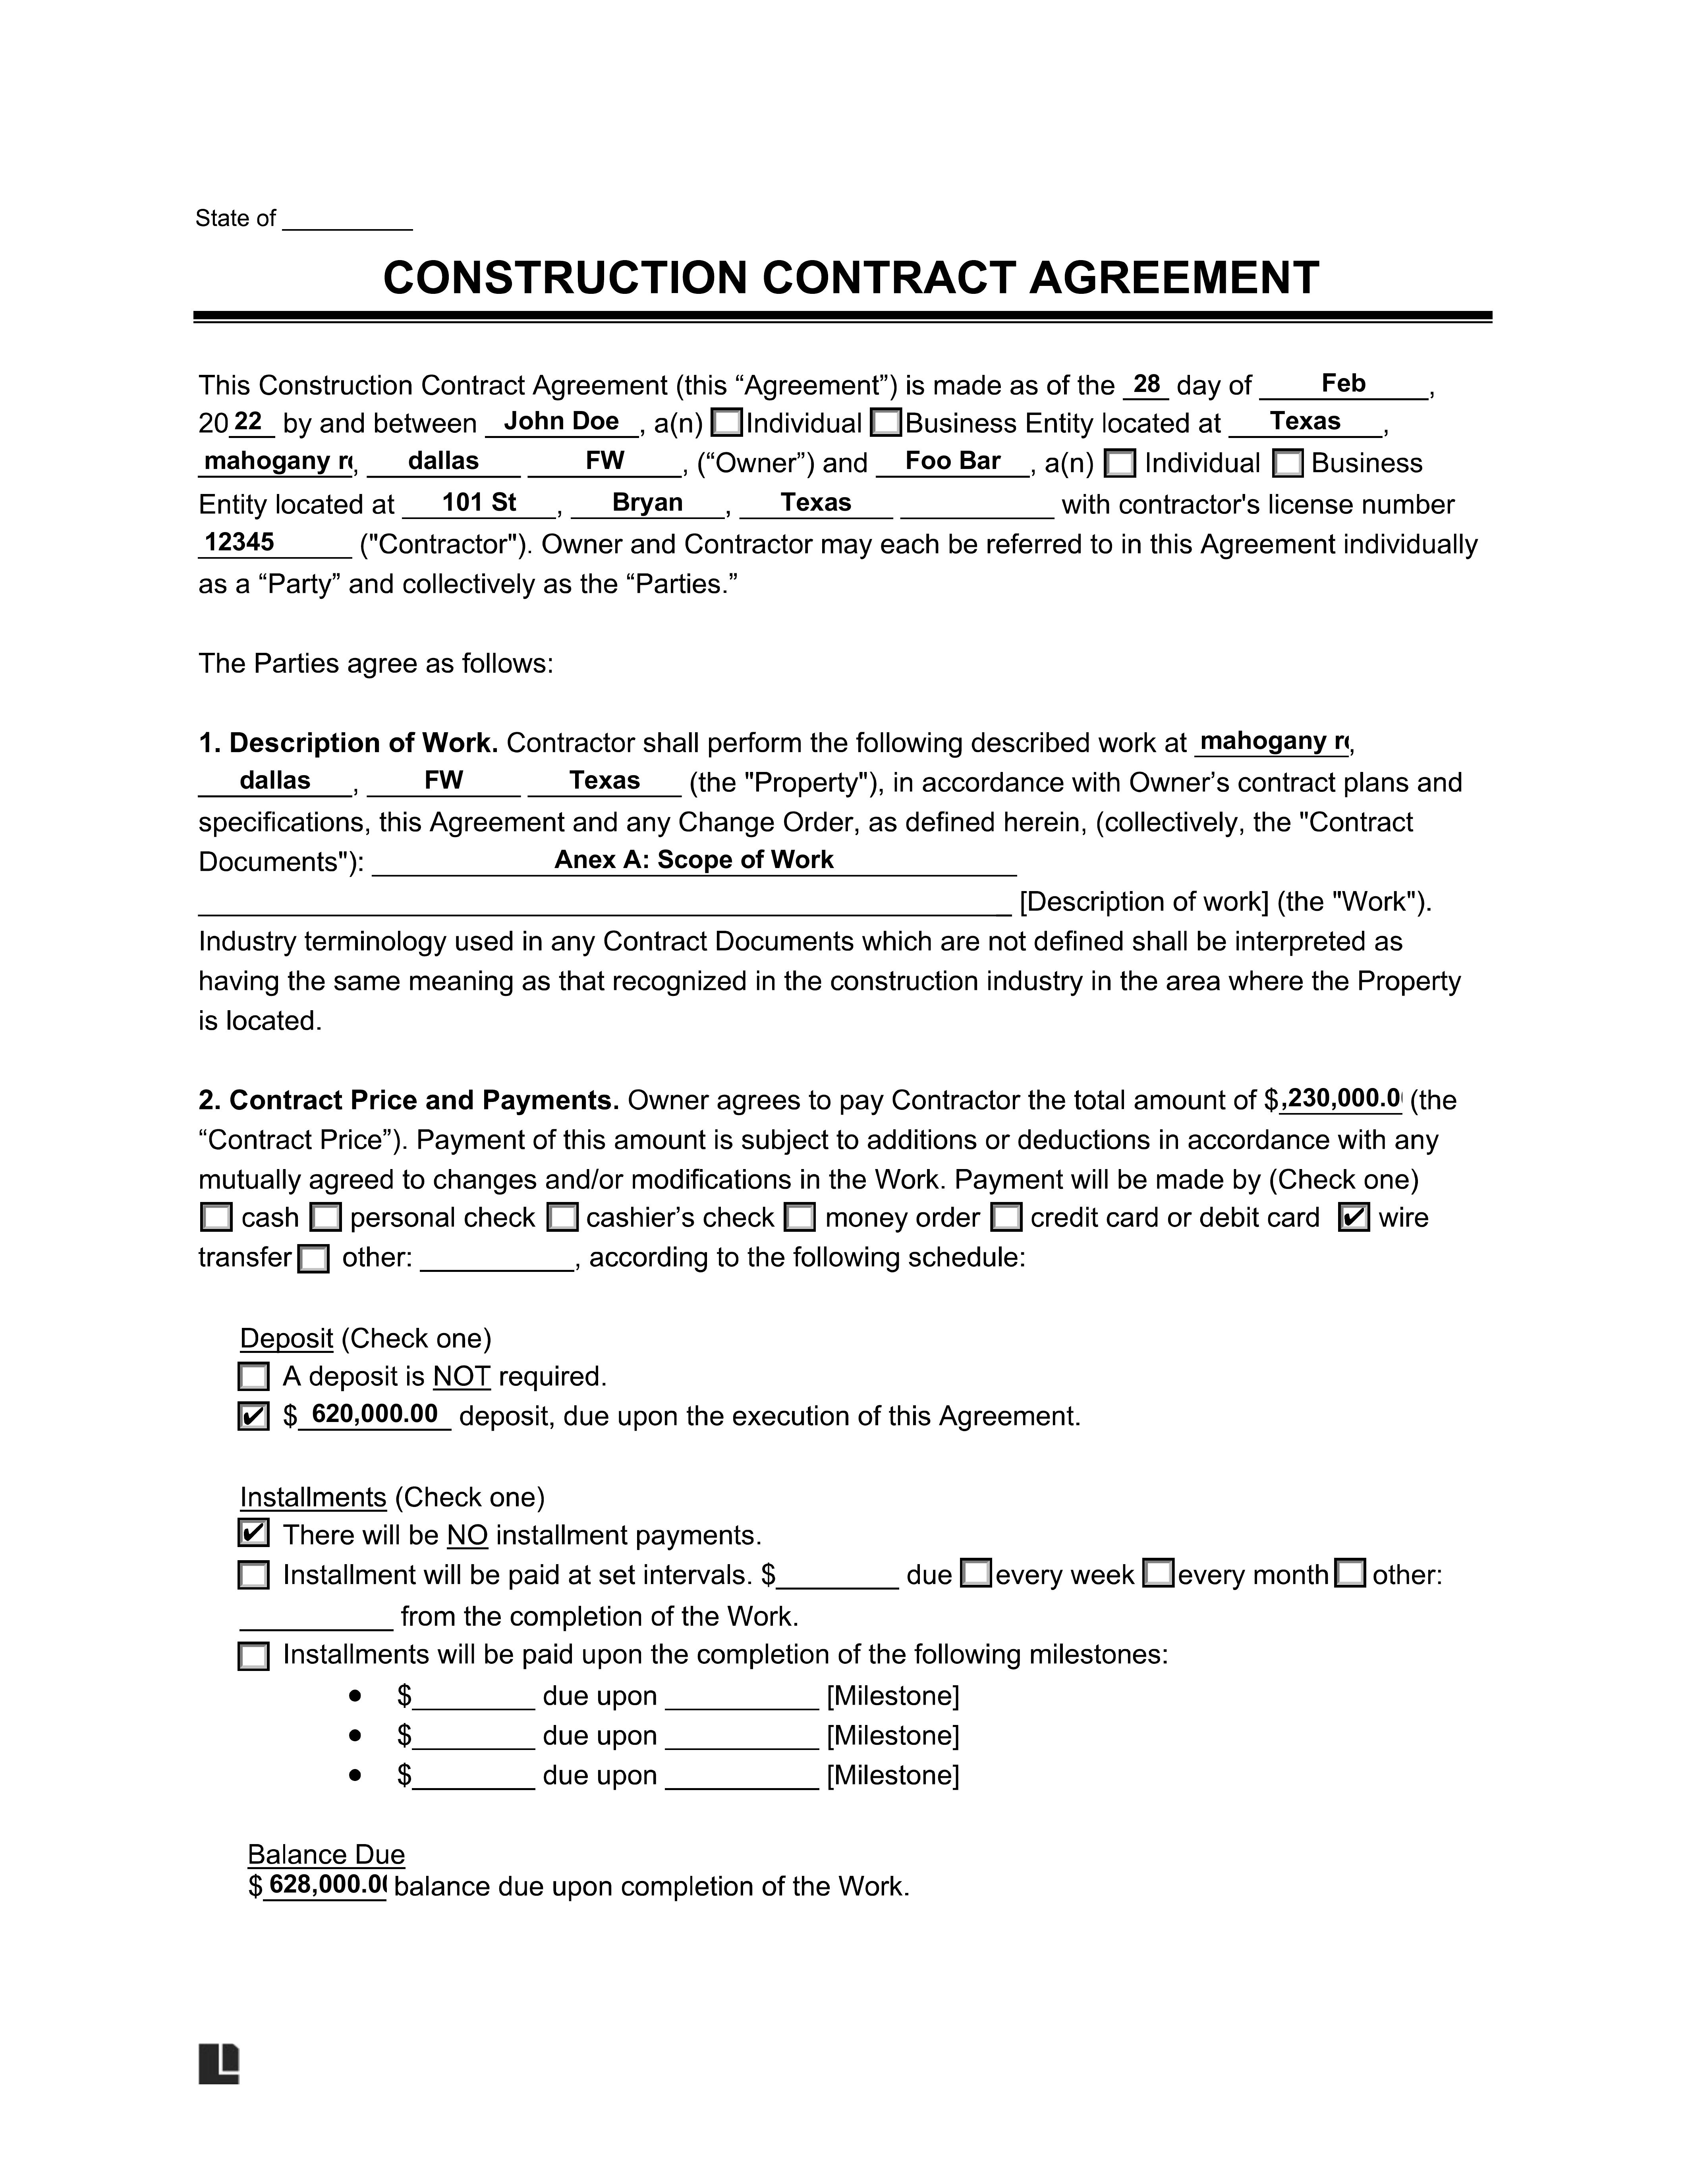

In [70]:
html = image_export_to_html("../data/amwins/img/page_0.jpg", 800,400)
IPython.display.HTML(html)

# GPT Embedding Search

In [6]:
import os
from langchain.llms.openai import OpenAI
from langchain.chains import RetrievalQA
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

In [7]:
os.environ['OPENAI_API_KEY']=  "YOUR OPEN AI KEY"

In [8]:
loader = TextLoader('../data/amwins/txt/contract_demo.txt', encoding='utf8')
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1_000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1783, which is longer than the specified 1000
Created a chunk of size 1085, which is longer than the specified 1000
Created a chunk of size 1783, which is longer than the specified 1000


In [9]:
# use GPT3.5 Embeddings
embeddings = OpenAIEmbeddings()
# load vector embeddings into Vector DB
db = Chroma.from_documents(texts, embeddings)

# set up Chroma as a retriever
retriever = db.as_retriever()
qa = RetrievalQA.from_chain_type(llm=OpenAI(), 
                                 chain_type="stuff", 
                                 retriever=retriever)


Using embedded DuckDB without persistence: data will be transient


In [10]:
# now that the retrieval chain is setup we can query it
query = "What is the contract value?"
print(qa.run(query).lstrip())

The contract value is $230,000.


In [11]:
query = "What is the name of the owner of the project?"
print(qa.run(query).lstrip())

The name of the owner of the project is John Doe.


In [12]:
query = "What is the deposit required in this contract?"
print(qa.run(query).lstrip())

The deposit required in this contract is $620,000.00.


In [13]:
query = "Can you tell me some risks that are present in this contract?"
print(qa.run(query).lstrip())

Some risks that are present in this contract include liability for any losses or damages covered by insurance, the potential for late or incomplete completion of the work, and any violations of applicable laws and regulations.


In [14]:
query = "is this project environmentally friendly?"
print(qa.run(query).lstrip())

No, this project is not necessarily environmentally friendly, as the contractor must take precautions to ensure hazardous materials are not present on the property.


In [15]:
query = "Is the owner black?"
print(qa.run(query).lstrip())

No, the owner is not mentioned in this context.


In [16]:
query = "Is there a clause for resolving dispute present in the contract?"
print(qa.run(query).lstrip())

Yes, there are several clauses for resolving disputes present in the contract, including court litigation, arbitration, mediation, and mediation then arbitration.


In [17]:
query = "Do you know any extreme risk of building a residential property in dallas, forth worth?"
print(qa.run(query).lstrip())

I do not know.


In [60]:
query = "provide me a short summary of the scope of this contract. Set temperature of answer to 0.1"
print(qa.run(query).lstrip())

This contract outlines an agreement between John Doe and Foo Bar for Contractor to perform construction work at mahogany rv. in Dallas FW, Texas for a total contract price of $230,000. The payment will be made with a $620,000 deposit upon the execution of this Agreement. The parties have also agreed to a waiver of subrogation and a clause making time of essence.


In [61]:
query = "provide me a short summary of the scope of this contract. Set temperature of answer to 1.8"
print(qa.run(query).lstrip())

This contract outlines an agreement between an Owner and Contractor for the completion of a Work. The Contract Price is $230,000 with an initial deposit of $620,000 due upon the execution of the agreement. There are no installment payments and the times stated in the Agreement may be extended due to causes beyond the Contractor's control. The Contractor may terminate the Agreement early if the Owner fails to make a progress payment for 30 days, and may recover from the Owner payment for all Work completed, materials, equipment, tools and machinery, and loss of reasonable profit.


# That's It!

we have seen how leveraging state of the art LLM can help in document understanding and knowledge extraction